In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_2D import data_generator
from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator

from loss_2D import generator_loss
from skimage import exposure
from skimage.exposure import match_histograms
from skimage.exposure import histogram

1 Physical GPUs, 1 Logical GPUs


In [5]:
patch_size = 256
n_patches =  16
n_channel =  0
augment = False 
shuffle = True 
batch_size = 1
add_noise=False

GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\train\2_rdriftcorrected.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\train\1_rdriftcorrected.tif'


x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold = 0,ratio=1.0,lp=0.4, augment=augment, shuffle=shuffle,
                                                   add_noise=add_noise)

(9, 1, 2048, 2048)
2304
The training set shape is: (2304, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


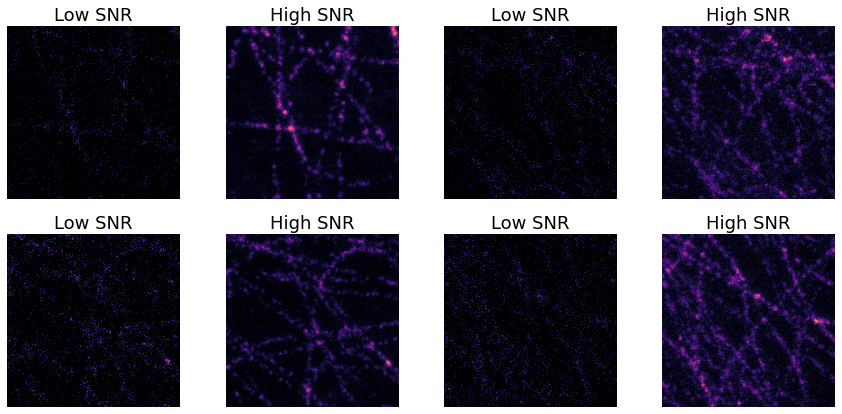

In [8]:
ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    norm_x = np.linalg.norm(x_train[ix[i]], axis=(0, 1))
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [9]:
model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5" 
load_model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-clathrine\clathrine\clathrine_2step_1.h5" 


n_epochs =  400
gen_lr = 1e-4

filters =[64,128,256]
# filters =[80,160,320,640]
num_filters = filters[0]
filters_cab=num_filters/8
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
generator.load_weights(load_model_save_directory)



lr_max = 1e-4
lr_min = 1e-6
T = 40
a1 = 0.7
a2 = 0.7
def scheduler(epoch, lr):
    lr_min_i = a1**np.floor((epoch)/T)*lr_min
    lr_max_i = a2**np.floor((epoch)/T)*lr_max
    lr = lr_min_i+0.5*(lr_max_i-lr_min_i)*(1+np.cos(np.pi*np.mod(epoch,T)/(T-1)))
    return lr

# def scheduler(epoch, lr):
#     lr = 1e-9*10**(epoch/20)
#     return lr

# lr_max = 2e-4
# lr_min = 1e-6
# a1 = 0.6
# T = 20
# def scheduler(epoch, lr):
#     if lr>lr_min:
#         lr = gen_lr*(a1**np.floor((epoch+1)/T))
#     else:
#         lr = lr_min
#     return lr

callbacks = [
    EarlyStopping(patience=100, verbose=1),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [
#     EarlyStopping(patience=100, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
#     ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [LearningRateScheduler(scheduler)]


In [ ]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.2)

Epoch 1/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1774 - conv2d_36_loss: 0.0888 - add_39_loss: 0.0886
Epoch 00001: val_loss improved from inf to 0.17874, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5
1843/1843 [==============================] - 275s 144ms/step - loss: 0.1774 - conv2d_36_loss: 0.0888 - add_39_loss: 0.0886 - val_loss: 0.1787 - val_conv2d_36_loss: 0.0892 - val_add_39_loss: 0.0895 - lr: 1.0000e-04
Epoch 2/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1768 - conv2d_36_loss: 0.0885 - add_39_loss: 0.0883
Epoch 00002: val_loss improved from 0.17874 to 0.17774, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5
1843/1843 [==============================] - 261s 142ms/step - loss: 0.1768 - conv2d_36_loss: 0.0885 - add_39_loss: 0.0883 - val_loss: 0.1777 - val_conv2d_36_loss: 0.0888 - val_add_39_loss: 0.0890 - lr: 9.9839e-05


1843/1843 [==============================] - ETA: 0s - loss: 0.1598 - conv2d_36_loss: 0.0800 - add_39_loss: 0.0798
Epoch 00018: val_loss improved from 0.16753 to 0.16736, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5
1843/1843 [==============================] - 255s 138ms/step - loss: 0.1598 - conv2d_36_loss: 0.0800 - add_39_loss: 0.0798 - val_loss: 0.1674 - val_conv2d_36_loss: 0.0837 - val_add_39_loss: 0.0837 - lr: 6.0401e-05
Epoch 19/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1587 - conv2d_36_loss: 0.0795 - add_39_loss: 0.0792
Epoch 00019: val_loss improved from 0.16736 to 0.16689, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5
1843/1843 [==============================] - 255s 138ms/step - loss: 0.1587 - conv2d_36_loss: 0.0795 - add_39_loss: 0.0792 - val_loss: 0.1669 - val_conv2d_36_loss: 0.0835 - val_add_39_loss: 0.0834 - lr: 5.6467e-05
Epoch 2

Epoch 35/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1499 - conv2d_36_loss: 0.0752 - add_39_loss: 0.0747
Epoch 00035: val_loss did not improve from 0.16096
1843/1843 [==============================] - 256s 139ms/step - loss: 0.1499 - conv2d_36_loss: 0.0752 - add_39_loss: 0.0747 - val_loss: 0.1610 - val_conv2d_36_loss: 0.0806 - val_add_39_loss: 0.0804 - lr: 4.9610e-06
Epoch 36/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1498 - conv2d_36_loss: 0.0752 - add_39_loss: 0.0746
Epoch 00036: val_loss did not improve from 0.16096
1843/1843 [==============================] - 256s 139ms/step - loss: 0.1498 - conv2d_36_loss: 0.0752 - add_39_loss: 0.0746 - val_loss: 0.1610 - val_conv2d_36_loss: 0.0806 - val_add_39_loss: 0.0804 - lr: 3.5474e-06
Epoch 37/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1497 - conv2d_36_loss: 0.0751 - add_39_loss: 0.0746
Epoch 00037: val_loss improved from 0.16096 to 0.16086, saving model to D:\Projects\De

Epoch 55/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1481 - conv2d_36_loss: 0.0745 - add_39_loss: 0.0737
Epoch 00055: val_loss improved from 0.15995 to 0.15954, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5
1843/1843 [==============================] - 256s 139ms/step - loss: 0.1481 - conv2d_36_loss: 0.0745 - add_39_loss: 0.0737 - val_loss: 0.1595 - val_conv2d_36_loss: 0.0800 - val_add_39_loss: 0.0795 - lr: 5.0204e-05
Epoch 56/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1477 - conv2d_36_loss: 0.0743 - add_39_loss: 0.0734
Epoch 00056: val_loss improved from 0.15954 to 0.15891, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5
1843/1843 [==============================] - 256s 139ms/step - loss: 0.1477 - conv2d_36_loss: 0.0743 - add_39_loss: 0.0734 - val_loss: 0.1589 - val_conv2d_36_loss: 0.0797 - val_add_39_loss: 0.0792 - lr: 4.763

Epoch 72/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1430 - conv2d_36_loss: 0.0724 - add_39_loss: 0.0707
Epoch 00072: val_loss improved from 0.15615 to 0.15597, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison twostep-onestep-rcan\tubulin_2step.h5
1843/1843 [==============================] - 282s 153ms/step - loss: 0.1430 - conv2d_36_loss: 0.0724 - add_39_loss: 0.0707 - val_loss: 0.1560 - val_conv2d_36_loss: 0.0784 - val_add_39_loss: 0.0775 - lr: 7.6493e-06
Epoch 73/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1429 - conv2d_36_loss: 0.0723 - add_39_loss: 0.0706
Epoch 00073: val_loss did not improve from 0.15597
1843/1843 [==============================] - 282s 153ms/step - loss: 0.1429 - conv2d_36_loss: 0.0723 - add_39_loss: 0.0706 - val_loss: 0.1562 - val_conv2d_36_loss: 0.0785 - val_add_39_loss: 0.0777 - lr: 6.0642e-06
Epoch 74/400
1843/1843 [==============================] - ETA: 0s - loss: 0.1428 - conv2d_36_loss: 0.072